In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import polytope
import numpy as np
from interval import interval, imath
from scipy.interpolate import interp1d

In [4]:
# Take a random network
# Simple example, 2 feature in 1 feature out
# The internal layers do not matter for now, except for the activation functions
net = nn.Sequential(
    nn.Linear(in_features=2, out_features=10, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=4, bias=True),
    nn.Sigmoid()
)

input_features = net[0].weight.shape[1]

input_size = net[0].weight.shape[0]

input_features

2

In [56]:
# Select the sampling region for the inputs and sampling interval
samples = 100

#set the seed for reproducibility
torch.random.manual_seed(100)

# Per feature uniform sampling
feat_1 = torch.distributions.uniform.Uniform(-3,3).sample([samples])
feat_2 = torch.distributions.uniform.Uniform(-3,3).sample([samples])

# Combine the features
feat = torch.stack([feat_1, feat_2],1)


In [57]:
# Evaluate the network in the sampled points
sample_output = net(feat)
poly_points = sample_output.detach().numpy()

poly_points_class_0 = np.reshape(poly_points[:,0], (samples, 1))
poly_points_class_1 = np.reshape(poly_points[:,1], (samples, 1))
poly_points_class_2 = np.reshape(poly_points[:,2], (samples, 1))
poly_points_class_3 = np.reshape(poly_points[:,3], (samples, 1))


In [76]:
# Create the polytope from the points
# this is the reachability set
poly0 = polytope.qhull(poly_points_class_0)
poly1 = polytope.qhull(poly_points_class_1)
poly2 = polytope.qhull(poly_points_class_2)
poly3 = polytope.qhull(poly_points_class_3)



([<matplotlib.axis.YTick at 0x31048a6d0>,
 [Text(0, 0, '0'), Text(0, 1, '1'), Text(0, 2, '2'), Text(0, 3, '3')])

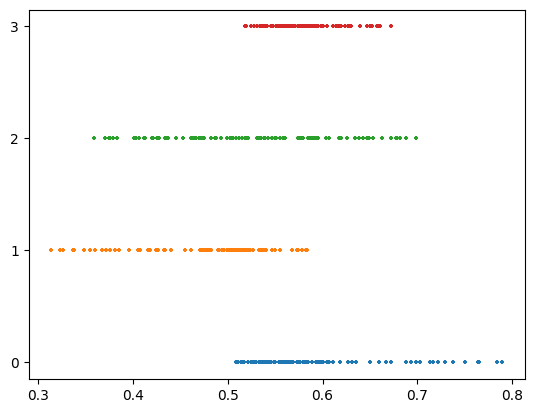

In [75]:
e0 = polytope.extreme(poly0)
e1 = polytope.extreme(poly1)

p0 = np.hstack( (np.zeros((len(poly_points_class_0), 1)), poly_points_class_0))
p1 = np.hstack( (np.ones((len(poly_points_class_1), 1)), poly_points_class_1))
p2 = np.hstack( (2*np.ones((len(poly_points_class_2), 1)), poly_points_class_2))
p3 = np.hstack( (3*np.ones((len(poly_points_class_3), 1)), poly_points_class_3))

plt.scatter(p0[:,1], p0[:,0], s=10, marker="+")
plt.scatter(p1[:,1], p1[:,0], s=10, marker="+")
plt.scatter(p2[:,1], p2[:,0], s=10, marker="+")
plt.scatter(p3[:,1], p3[:,0], s=10, marker="+")

plt.yticks([0,1,2,3])

In [74]:
# Print the equations for PVS
# A x <= b
A = []
b = []

eq_buff = []
for i,b in enumerate(b):
    str_buff = []
    for j,a in enumerate(A[i]):
        str_buff.append(str(a)+"*x"+str(j))
    eq_buff.append("+".join(str_buff)+ "<=" + str(b))

and_string = " AND ".join(eq_buff)

and_string

''

In [37]:
import interval_tensor
from interval_tensor import IntervalTensor

def extract_output_tensor(interval_tensor):
    idata = interval_tensor.data()
    out_data = [0] * len(idata)
    for l_, i_ in enumerate(idata):
        feat_ = np.array(i_[0]).reshape(2, 1)
        label_ = (np.ones(2) * l_).reshape(2, 1)
        stacked = np.hstack((label_, feat_))
        out_data[l_] = stacked
    return out_data

In [72]:
intervals = np.array([[-3,3],[-3,3]], dtype=object)
i = IntervalTensor(intervals)
o =  net(i)
bounds=extract_output_tensor(o)
bb=np.array(bounds).reshape(8,2)

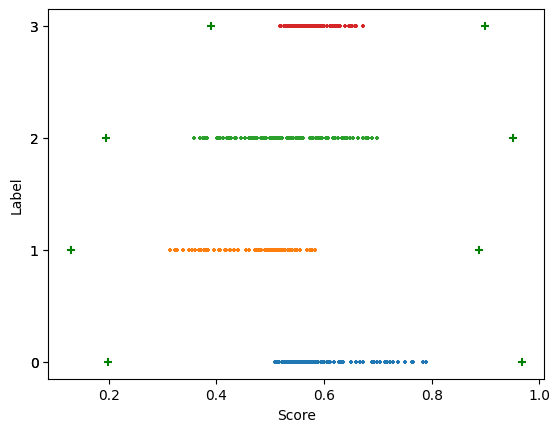

In [73]:
plt.scatter(p0[:,1], p0[:,0], s=10, marker="+")
plt.scatter(p1[:,1], p1[:,0], s=10, marker="+")
plt.scatter(p2[:,1], p2[:,0], s=10, marker="+")
plt.scatter(p3[:,1], p3[:,0], s=10, marker="+")
plt.scatter(bb[:,1], bb[:,0], color="green", marker="+");
plt.ylabel("Label")
plt.xlabel("Score")
plt.yticks(bb[:,0]);